In [503]:
import pandas as pd
import sqlite3
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import csv

import seaborn as sns
import matplotlib.pyplot as plt

# Import XGBoost classifier
from xgboost import XGBClassifier

# Import scikit-learn functions
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Import scikit-plot functions
from scikitplot.metrics import plot_roc_curve
from scikitplot.metrics import plot_precision_recall_curve
from scikitplot.metrics import plot_calibration_curve

# Import SciPy function
from scipy.spatial import distance

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [504]:
# Data Directory
data_dir = "../../Data/Big-Data-Cup-2021"
bucketless_data_dir = '../../Data/bdc/data'
tracking_data_dir = "{}/TrackingData".format(data_dir)
db_path = '/Users/keltim01/Documents/databases/'

#connect to database 
conn = sqlite3.connect(db_path + 'bdc_2022.db')
cursor = conn.cursor()

In [505]:
# important numbers for the hockey rink 
ICE_LENGTH = 200
ICE_WIDTH = 85
GOAL_X = ICE_LENGTH - 10
GOAL_Y = ICE_WIDTH / 2
D_ZONE = 75
O_ZONE = ICE_LENGTH - 75

## Using tracking data to find a way to classify teams in creating "danger" on the powerplay by creating space. 

- with tracking data get totally away from shots as basis of structure but take locations of players as structure → also maybe get away from shots as basis at all
- xG everywhere not shots to be able to classify? 
- Combine tracking and event data to look at nearest defender for attackers on the powerplay
- factor in shot selection: xG shoot now, xG Pass etc.
- BART model?

Important questions: 
- Who is good in creating space? 
- Who creates more dangerous situations (more xG)? 
- Who creates danger and space in formation? 
- Who uses good chances (finishing) or selects good shots?  

In [506]:
# Merging Tracking and Play-by-Play data 
df_tracking = pd.read_sql('SELECT * FROM tracking', conn)

In [507]:
df_pbp_pp = pd.read_sql('SELECT * FROM play_by_play WHERE frame_id_1 IS NOT NULL AND strength_state > 0', conn) 

In [508]:
df_pbp_pp.head()

,level_0,index,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,player_name,event,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3,frame_id_1,frame_id_2,home_team,away_team,game_id,is_shot,is_goal,event_id,team_id,player_id,detail_1_code,goal_diff,game_seconds_remaining,event_code,event_type_code,skaters_for,skaters_against,strength_state,distance_to_goal,angle_to_goal,prev_event,prev_event_code,prev_event_type,prev_event_type_code,prev_event_x_coord,prev_event_y_coord,prev_event_game_seconds_remaining,prev_event_distance_to_goal,prev_event_angle_to_goal,time_diff_last_event,angle_diff_last_event,distance_diff_last_event,second_prev_event,second_prev_event_code,second_prev_event_type,second_prev_event_type_code,second_prev_event_x_coord,second_prev_event_y_coord,second_prev_event_game_seconds_remaining,second_prev_event_distance_to_goal,second_prev_event_angle_to_goal,prev_time_diff_last_event,prev_angle_diff_last_event,prev_distance_diff_last_event,non_shot_expected_goals,expected_goals
0,441,441,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,375,5 on 4,0,0,Brianne Jenner,Play,1,185,7,Direct,Marie-Philip Poulin,139.0,5.0,None,0,0,344.0,370.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,17,-1,0,2775.0,3,6,5,4,1,35.850384,0.140845,Play,3.0,Indirect,15.0,194.0,66.0,2778.0,23.837995,-0.170213,-3.0,0.311058,12.012389,Puck Recovery,4.0,None,-1.0,165.0,82.0,2780.0,46.746658,0.632911,-2.0,-0.803124,-22.908663,0.189897,NaN
1,442,442,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,373,5 on 4,0,0,Marie-Philip Poulin,Play,1,161,3,Direct,Rebecca Johnston,143.0,19.0,None,0,0,420.0,443.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,60,-1,0,2773.0,3,6,5,4,1,49.002551,0.734177,Play,3.0,Direct,6.0,185.0,7.0,2775.0,35.850384,0.140845,-2.0,0.593332,13.152167,Play,3.0,Indirect,15.0,194.0,66.0,2778.0,23.837995,-0.170213,-3.0,0.311058,12.012389,0.189897,NaN
2,443,443,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,366,5 on 4,0,0,Rebecca Johnston,Play,1,176,3,Direct,Marie-Philip Poulin,130.0,17.0,None,0,0,605.0,639.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,81,-1,0,2766.0,3,6,5,4,1,41.907637,0.354430,Play,3.0,Direct,6.0,161.0,3.0,2773.0,49.002551,0.734177,-7.0,-0.379747,-7.094914,Play,3.0,Direct,6.0,185.0,7.0,2775.0,35.850384,0.140845,-2.0,0.593332,13.152167,0.189897,NaN
3,444,444,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,365,5 on 4,0,0,Marie-Philip Poulin,Play,1,130,17,Direct,Erin Ambrose,133.0,55.0,None,0,0,650.0,670.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,60,-1,0,2765.0,3,6,5,4,1,65.193941,2.352941,Play,3.0,Direct,6.0,176.0,3.0,2766.0,41.907637,0.354430,-1.0,1.998511,23.286305,Play,3.0,Direct,6.0,161.0,3.0,2773.0,49.002551,0.734177,-7.0,-0.379747,-7.094914,0.189897,NaN
4,445,445,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,363,5 on 4,0,0,Erin Ambrose,Play,1,139,55,Direct,Brianne Jenner,176.0,42.0,None,0,0,701.0,718.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,29,-1,0,2763.0,3,6,5,4,1,52.509523,4.080000,Play,3.0,Direct,6.0,130.0,17.0,2765.0,65.193941,2.352941,-2.0,1.727059,-12.684418,Play,3.0,Direct,6.0,176.0,3.0,2766.0,41.907637,0.354430,-1.0,1.998511,23.286305,0.189897,NaN


In [509]:
df_tracking.head()

,index,frame_id,period,track_id,team_id,team_name,jersey_number,x_coord,y_coord,video_shot,game_seconds,venue,player,position,game_id
0,0,96,1,2,Light,ROC,100,176.651307,52.308133,1,2590,away,None,None,4
1,1,96,1,3,Light,ROC,27,158.782222,41.325801,1,2590,away,Veronika Korzhakova,Center,4
2,2,96,1,4,Dark,Finland,10,151.138502,51.883526,1,2590,home,Elisa Holopainen,Left Wing,4
3,3,96,1,5,Light,ROC,100,163.814533,59.253376,1,2590,away,None,None,4
4,4,96,1,8,Dark,Finland,88,165.000000,50.000000,1,2590,home,Ronja Savolainen,Defense,4


In [510]:
test_pbp = df_pbp_pp.loc[df_pbp_pp['frame_id_1'] == 96]

In [511]:
test_tracking = df_tracking[(df_tracking['frame_id'] == 108) & (df_tracking['game_id'] == 5) & (df_tracking['period'] == 1)]

In [512]:
df_tracking.columns

Index(['index', 'frame_id', 'period', 'track_id', 'team_id', 'team_name',
       'jersey_number', 'x_coord', 'y_coord', 'video_shot', 'game_seconds',
       'venue', 'player', 'position', 'game_id'],
      dtype='object')

In [513]:
df_pbp_pp.columns

Index(['level_0', 'index', 'game_date', 'season_year', 'team_name',
       'opp_team_name', 'venue', 'period', 'clock_seconds', 'situation_type',
       'goals_for', 'goals_against', 'player_name', 'event',
       'event_successful', 'x_coord', 'y_coord', 'event_type', 'player_name_2',
       'x_coord_2', 'y_coord_2', 'event_detail_1', 'event_detail_2',
       'event_detail_3', 'frame_id_1', 'frame_id_2', 'home_team', 'away_team',
       'game_id', 'is_shot', 'is_goal', 'event_id', 'team_id', 'player_id',
       'detail_1_code', 'goal_diff', 'game_seconds_remaining', 'event_code',
       'event_type_code', 'skaters_for', 'skaters_against', 'strength_state',
       'distance_to_goal', 'angle_to_goal', 'prev_event', 'prev_event_code',
       'prev_event_type', 'prev_event_type_code', 'prev_event_x_coord',
       'prev_event_y_coord', 'prev_event_game_seconds_remaining',
       'prev_event_distance_to_goal', 'prev_event_angle_to_goal',
       'time_diff_last_event', 'angle_diff_last_event

In [514]:
df_pbp_pp[['frame_id_1','frame_id_2']].info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   frame_id_1  861 non-null    float64
 1   frame_id_2  440 non-null    float64
dtypes: float64(2)
memory usage: 13.6 KB


In [515]:
df_pbp_pp[df_pbp_pp['frame_id_1'] == 867]

,level_0,index,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,player_name,event,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3,frame_id_1,frame_id_2,home_team,away_team,game_id,is_shot,is_goal,event_id,team_id,player_id,detail_1_code,goal_diff,game_seconds_remaining,event_code,event_type_code,skaters_for,skaters_against,strength_state,distance_to_goal,angle_to_goal,prev_event,prev_event_code,prev_event_type,prev_event_type_code,prev_event_x_coord,prev_event_y_coord,prev_event_game_seconds_remaining,prev_event_distance_to_goal,prev_event_angle_to_goal,time_diff_last_event,angle_diff_last_event,distance_diff_last_event,second_prev_event,second_prev_event_code,second_prev_event_type,second_prev_event_type_code,second_prev_event_x_coord,second_prev_event_y_coord,second_prev_event_game_seconds_remaining,second_prev_event_distance_to_goal,second_prev_event_angle_to_goal,prev_time_diff_last_event,prev_angle_diff_last_event,prev_distance_diff_last_event,non_shot_expected_goals,expected_goals
718,9787,9787,16/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Finland,away,2,566,5 on 4,0,1,Andrea Brandli,Puck Recovery,1,22,56,None,None,NaN,NaN,None,0,0,867.0,NaN,Olympic (Women) - Finland,Olympic (Women) - Switzerland,3,0,0,4,3,8,-1,-1,1766.0,4,-1,5,4,1,168.541538,12.444444,Dump In/Out,0.0,None,-1.0,53.0,40.0,1769.0,137.022808,54.800000,-3.0,-42.355556,31.518730,Puck Recovery,4.0,None,-1.0,54.0,44.0,1769.0,136.008272,90.666667,0.0,-35.866667,1.014537,0.328330,NaN
719,9788,9788,16/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Finland,away,2,566,5 on 4,0,1,Andrea Brandli,Play,1,22,56,Direct,Lara Christen,41.0,59.0,None,0,0,867.0,906.0,Olympic (Women) - Finland,Olympic (Women) - Switzerland,3,0,0,3,3,8,-1,-1,1766.0,3,6,5,4,1,168.541538,12.444444,Puck Recovery,4.0,None,-1.0,22.0,56.0,1766.0,168.541538,12.444444,0.0,0.000000,0.000000,Dump In/Out,0.0,None,-1.0,53.0,40.0,1769.0,137.022808,54.800000,-3.0,-42.355556,31.518730,0.328330,NaN
750,9949,9949,16/2/2022,2021,Olympic (Women) - Finland,Olympic (Women) - Switzerland,home,2,200,5 on 4,1,0,Elisa Holopainen,Play,0,166,20,Direct,Nelli Laitinen,164.0,65.0,None,0,0,867.0,NaN,Olympic (Women) - Finland,Olympic (Women) - Switzerland,3,0,0,3,1,23,-1,1,1400.0,3,6,5,4,1,32.897568,1.066667,Play,3.0,Direct,6.0,131.0,50.0,1401.0,59.474785,7.866667,-1.0,-6.800000,-26.577216,Play,3.0,Direct,6.0,144.0,79.0,1403.0,58.721802,1.260274,-2.0,6.606393,0.752983,0.189897,NaN


In [516]:
df_pbp_pp.loc[11,'frame_id_1']

1028.0

In [522]:
df_distance = pd.DataFrame(index=df_pbp_pp.index)
dfs_distance = []
for index in df_pbp_pp.index:
    test_pbp = df_pbp_pp.loc[index]
    test_pbp_next = df_pbp_pp.loc[index]
    test_tracking = df_tracking[(df_tracking['frame_id'] == test_pbp['frame_id_1']) & (df_tracking['game_id'] == test_pbp['game_id']) & (df_tracking['period'] == test_pbp['period'])]
    if (test_pbp['player_name'] in test_tracking['player'].to_list()) & (test_pbp_next['x_coord'] >= O_ZONE):
        diff_x1 = test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'x_coord'] - test_tracking.loc[test_tracking['player'] == test_pbp['player_name'],'x_coord'].values[0]
        diff_x1 = diff_x1.astype(float)
        diff_y1 = abs(test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'y_coord'] - test_tracking.loc[test_tracking['player'] == test_pbp['player_name'],'y_coord'].values[0])
        pl_distance = np.sqrt(diff_x1**2 + diff_y1**2)
        dfs_distance.append(pl_distance.min())
    else:
        if (test_tracking.size > 0) & (test_pbp_next['x_coord'] >= O_ZONE): 
            diff_x1 = test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'x_coord'] - test_pbp['x_coord']
            diff_x1 = diff_x1.astype(float)
            diff_y1 = abs(test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'y_coord'] - test_pbp['y_coord'])
            pl_distance = np.sqrt(diff_x1**2 + diff_y1**2)
            dfs_distance.append(pl_distance.min())
        else: 
            dfs_distance.append(np.nan)
    


In [526]:
df_pbp_pp['nearest_defender'] = dfs_distance

In [527]:
df_pbp_pp['diff_nearest_defender'] = df_pbp_pp['nearest_defender'] - df_pbp_pp['nearest_defender'].shift(1)
df_pbp_pp['diff_nearest_defender_prev'] = df_pbp_pp['nearest_defender'].shift(-1) - df_pbp_pp['nearest_defender']
df_pbp_pp['net_diff_nearest_defender'] = df_pbp_pp['diff_nearest_defender'] + df_pbp_pp['diff_nearest_defender_prev']
df_pbp_pp['xg_weighted_nearest_defender'] = df_pbp_pp['nearest_defender'] * df_pbp_pp['non_shot_expected_goals']
df_pbp_pp['xg_weighted_diff_nearest_defender'] = df_pbp_pp['xg_weighted_nearest_defender'] - df_pbp_pp['xg_weighted_nearest_defender'].shift(1)
df_pbp_pp['xg_weighted_diff_nearest_defender_prev'] = df_pbp_pp['xg_weighted_nearest_defender'].shift(-1) - df_pbp_pp['xg_weighted_nearest_defender']
df_pbp_pp['xg_weighted_net_diff_nearest_defender'] = df_pbp_pp['xg_weighted_diff_nearest_defender'] + df_pbp_pp['xg_weighted_diff_nearest_defender_prev']

In [528]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender']].groupby('player_name').mean().sort_values('diff_nearest_defender', ascending=False).head(25)

,expected_goals,nearest_defender,diff_nearest_defender
player_name,,,
Mich Zandee-Hart,NaN,18.449790,15.548812
Claire Thompson,NaN,21.254883,10.685002
Cayla Barnes,NaN,15.412685,9.196930
Shannon Sigrist,NaN,12.220417,7.949567
Kelly Pannek,NaN,13.997428,7.019931
Sinja Leemann,NaN,16.678921,6.770487
Keely Moy,NaN,14.057871,5.904524
Anna Savonina,NaN,20.003402,5.119510
Angelina Goncharenko,NaN,19.345223,4.850618


In [529]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender']].groupby('player_name').sum().sort_values('diff_nearest_defender', ascending=False).head(10)

,expected_goals,nearest_defender,diff_nearest_defender
player_name,,,
Sinja Leemann,0.0,116.752449,47.393412
Cayla Barnes,0.0,77.063425,45.984648
Alex Carpenter,0.0,106.200240,32.110952
Claire Thompson,0.0,63.764650,32.055006
Evelina Raselli,0.0,142.792860,27.931170
Jenni Hiirikoski,0.0,146.768955,26.889833
Olga Sosina,0.0,183.714598,25.575017
Kelly Pannek,0.0,55.989713,21.059792
Lara Christen,0.0,259.941557,20.678896


In [530]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender']].groupby('player_name').mean().sort_values('diff_nearest_defender', ascending=True).head(25)

,expected_goals,nearest_defender,diff_nearest_defender
player_name,,,
Alexandra Vafina,NaN,14.101400,-10.258372
Kendall Coyne Schofield,NaN,4.592765,-8.757260
Ashton Bell,NaN,9.993587,-8.456202
Noora Tulus,NaN,11.629361,-8.345131
Jocelyne Larocque,NaN,13.063508,-7.649675
Alina Muller,NaN,10.520674,-7.506383
Susanna Tapani,NaN,8.669960,-6.014260
Jincy Dunne,NaN,7.659443,-4.136515
Rahel Enzler,NaN,6.563676,-3.537414


In [531]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender']].groupby('team_name').sum().sort_values('diff_nearest_defender', ascending=False)

,expected_goals,nearest_defender,diff_nearest_defender
team_name,,,
Olympic (Women) - United States,0.0,777.804815,71.388897
Olympic (Women) - Canada,0.0,584.474245,43.365532
Olympic (Women) - Olympic Athletes from Russia,0.0,611.317763,13.944606
Olympic (Women) - Finland,0.0,1311.802849,11.971210
Olympic (Women) - Switzerland,0.0,1000.942936,-21.018984


In [532]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender']].groupby('player_name').mean().sort_values('diff_nearest_defender', ascending=True)

,expected_goals,nearest_defender,diff_nearest_defender
player_name,,,
Alexandra Vafina,NaN,14.101400,-10.258372
Kendall Coyne Schofield,NaN,4.592765,-8.757260
Ashton Bell,NaN,9.993587,-8.456202
Noora Tulus,NaN,11.629361,-8.345131
Jocelyne Larocque,NaN,13.063508,-7.649675
Alina Muller,NaN,10.520674,-7.506383
Susanna Tapani,NaN,8.669960,-6.014260
Jincy Dunne,NaN,7.659443,-4.136515
Rahel Enzler,NaN,6.563676,-3.537414


In [533]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & ((df_pbp_pp['x_coord_2'] >= O_ZONE) | (df_pbp_pp['x_coord_2'].isna())) & (df_pbp_pp['player_name'] == "Keely Moy"), :]

,level_0,index,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,player_name,event,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3,frame_id_1,frame_id_2,home_team,away_team,game_id,is_shot,is_goal,event_id,team_id,player_id,detail_1_code,goal_diff,game_seconds_remaining,event_code,event_type_code,skaters_for,skaters_against,strength_state,distance_to_goal,angle_to_goal,prev_event,prev_event_code,prev_event_type,prev_event_type_code,prev_event_x_coord,prev_event_y_coord,prev_event_game_seconds_remaining,prev_event_distance_to_goal,prev_event_angle_to_goal,time_diff_last_event,angle_diff_last_event,distance_diff_last_event,second_prev_event,second_prev_event_code,second_prev_event_type,second_prev_event_type_code,second_prev_event_x_coord,second_prev_event_y_coord,second_prev_event_game_seconds_remaining,second_prev_event_distance_to_goal,second_prev_event_angle_to_goal,prev_time_diff_last_event,prev_angle_diff_last_event,prev_distance_diff_last_event,non_shot_expected_goals,expected_goals,nearest_defender,diff_nearest_defender,diff_nearest_defender_prev,net_diff_nearest_defender,xg_weighted_nearest_defender,xg_weighted_diff_nearest_defender,xg_weighted_diff_nearest_defender_prev,xg_weighted_net_diff_nearest_defender
275,3789,3789,12/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Olympic Athletes from Russia,away,1,733,5 on 4,0,0,Keely Moy,Puck Recovery,1,186,57,None,None,NaN,NaN,None,0,0,477.0,NaN,Olympic (Women) - Olympic Athletes from Russia,Olympic (Women) - Switzerland,0,0,0,4,3,45,-1,0,3133.0,4,-1,5,4,1,15.041609,0.275862,Shot,5.0,Slapshot,19.0,135.0,39.0,3134.0,55.111251,15.714286,-1.0,-15.438424,-40.069642,Play,3.0,Direct,6.0,129.0,60.0,3135.0,63.460618,3.485714,-1.0,12.228571,-8.349367,0.287355,NaN,4.215198,-12.754853,0.000000,-12.754853,1.211259,-2.011309,-0.076043,-2.087351
276,3790,3790,12/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Olympic Athletes from Russia,away,1,733,5 on 4,0,0,Keely Moy,Shot,0,186,57,Snapshot,None,NaN,NaN,Missed,0,0,477.0,NaN,Olympic (Women) - Olympic Athletes from Russia,Olympic (Women) - Switzerland,0,1,0,5,3,45,1,0,3133.0,5,21,5,4,1,15.041609,0.275862,Puck Recovery,4.0,None,-1.0,186.0,57.0,3133.0,15.041609,0.275862,0.0,0.000000,0.000000,Shot,5.0,Slapshot,19.0,135.0,39.0,3134.0,55.111251,15.714286,-1.0,-15.438424,-40.069642,0.269315,0.128946,4.215198,0.000000,6.985655,6.985655,1.135216,-0.076043,2.422989,2.346946
281,3797,3797,12/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Olympic Athletes from Russia,away,1,723,5 on 4,0,0,Keely Moy,Play,0,196,63,Direct,Lara Christen,187.0,47.0,None,0,0,762.0,NaN,Olympic (Women) - Olympic Athletes from Russia,Olympic (Women) - Switzerland,0,0,0,3,3,45,-1,0,3123.0,3,6,5,4,1,21.360009,-0.292683,Play,3.0,Indirect,15.0,165.0,70.0,3126.0,37.165172,0.909091,-3.0,-1.201774,-15.805163,Puck Recovery,4.0,None,-1.0,165.0,70.0,3126.0,37.165172,0.909091,0.0,0.000000,0.000000,0.198701,NaN,15.842776,9.207923,NaN,NaN,3.147975,1.888034,NaN,NaN
348,5001,5001,12/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Olympic Athletes from Russia,away,3,726,5 on 4,2,1,Keely Moy,Play,1,195,32,Direct,Phoebe Staenz,181.0,41.0,None,0,0,549.0,561.0,Olympic (Women) - Olympic Athletes from Russia,Olympic (Women) - Switzerland,0,0,0,3,3,45,-1,1,726.0,3,6,5,4,1,11.629703,-0.476190,Play,3.0,Direct,6.0,132.0,83.0,730.0,70.740724,1.432099,-4.0,-1.908289,-59.111020,Puck Recovery,4.0,None,-1.0,126.0,83.0,733.0,75.738035,1.580247,-3.0,-0.148148,-4.997312,0.214259,NaN,12.272966,2.601126,-5.793425,-3.192300,2.629592,0.792935,-0.895752,-0.102817
369,5037,5037,12/2/2022,2021,Olympic (Women) - Switzerland,Olympic (Women) - Olympic Athletes from Russia,away,3,659,5 on 4,2,1,Keely Moy,Faceoff Win,1,169,65,Backhand,Yekaterina Dobrodeyeva,NaN,NaN,None,0,0,4382.0,NaN,Olympic (Women) - Olympic Athletes from Russia,Olympic

In [534]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),'diff_nearest_defender'].mean(), df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE),'diff_nearest_defender'].mean()

(0.38473074483571035, 0.025971164662978573)

In [535]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender', 'diff_nearest_defender_prev', 'net_diff_nearest_defender']].groupby('player_name').mean().sort_values('diff_nearest_defender_prev', ascending=True)

,expected_goals,nearest_defender,diff_nearest_defender,diff_nearest_defender_prev,net_diff_nearest_defender
player_name,,,,,
Mich Zandee-Hart,NaN,18.449790,15.548812,-8.456202,7.092610
Anna Savonina,NaN,20.003402,5.119510,-7.933817,-2.814306
Jenni Hiirikoski,NaN,20.966994,3.841405,-7.814476,-3.973071
Claire Thompson,NaN,21.254883,10.685002,-6.706039,3.978963
Keely Moy,NaN,14.057871,5.904524,-5.793425,-3.192300
Lara Christen,NaN,17.329437,1.378593,-5.432029,-3.733227
Angelina Goncharenko,NaN,19.345223,4.850618,-5.314984,1.982489
Evelina Raselli,NaN,12.981169,3.103463,-4.947664,-1.646461
Hannah Brandt,NaN,10.010130,3.444919,-4.652155,1.779188


In [536]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & (df_pbp_pp['x_coord_2'] >= O_ZONE | df_pbp_pp['x_coord_2'].isna()),['player_name','team_name', 'expected_goals','nearest_defender','diff_nearest_defender', 'diff_nearest_defender_prev', 'net_diff_nearest_defender']].groupby('player_name').mean().sort_values('net_diff_nearest_defender', ascending=False)

,expected_goals,nearest_defender,diff_nearest_defender,diff_nearest_defender_prev,net_diff_nearest_defender
player_name,,,,,
Emily Clark,NaN,2.900977,0.380667,15.548812,15.929479
Dani Cameranesi,NaN,6.483289,3.850166,8.225663,12.075829
Phoebe Staenz,NaN,8.027835,0.000000,9.865178,9.865178
Nina Pirogova,NaN,10.200205,-0.064807,9.067799,9.002992
Viivi Vainikka,NaN,6.439402,-0.386380,8.064379,8.966733
Hilary Knight,NaN,7.192234,1.559156,5.278605,8.201104
Sanni Rantala,NaN,14.938862,1.951729,5.277014,7.228743
Mich Zandee-Hart,NaN,18.449790,15.548812,-8.456202,7.092610
Alex Carpenter,NaN,10.620024,3.211095,4.394147,6.748496


In [537]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & ((df_pbp_pp['x_coord_2'] >= O_ZONE) | (df_pbp_pp['x_coord_2'].isna())),['player_name','team_name','xg_weighted_nearest_defender','xg_weighted_diff_nearest_defender', 'xg_weighted_diff_nearest_defender_prev','net_diff_nearest_defender', 'xg_weighted_net_diff_nearest_defender']].groupby('player_name').mean().sort_values('xg_weighted_net_diff_nearest_defender', ascending=False)

,xg_weighted_nearest_defender,xg_weighted_diff_nearest_defender,xg_weighted_diff_nearest_defender_prev,net_diff_nearest_defender,xg_weighted_net_diff_nearest_defender
player_name,,,,,
Jamie Lee Rattray,1.854930,-0.042826,2.713516,14.063860,2.670690
Kendall Coyne Schofield,1.125796,-1.045641,1.603230,-0.258694,1.440063
Mich Zandee-Hart,3.503566,2.952678,-1.605810,7.092610,1.346868
Emily Clark,2.373803,-0.184622,1.512483,6.992522,1.327861
Claire Thompson,3.629260,1.495018,-0.260163,6.441079,1.234855
Sanni Rantala,3.038201,0.813021,0.416894,6.462138,1.229915
Fanuza Kadirova,0.716064,-0.069465,1.207368,2.516568,1.137903
Sinja Leemann,3.232042,1.092957,-0.317606,3.578255,0.917241
Lara Stalder,2.289163,0.034284,0.553259,3.300264,0.821954


In [538]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & ((df_pbp_pp['x_coord_2'] >= O_ZONE) | (df_pbp_pp['x_coord_2'].isna())),['event','net_diff_nearest_defender','xg_weighted_net_diff_nearest_defender']].groupby('event').mean().sort_values('xg_weighted_net_diff_nearest_defender', ascending=False)

,net_diff_nearest_defender,xg_weighted_net_diff_nearest_defender
event,,
Dump In/Out,27.715458,5.237250
Play,1.464175,0.148146
Shot,-3.275902,-0.053634
Puck Recovery,-2.096465,-0.500509
Zone Entry,-5.526446,-1.049458
Faceoff Win,-3.565558,-1.381642
Takeaway,-10.222039,-1.922537


In [539]:
df_pbp_pp.loc[(df_pbp_pp['x_coord'] >= O_ZONE) & ((df_pbp_pp['x_coord_2'] >= O_ZONE) | (df_pbp_pp['x_coord_2'].isna())),'event'].value_counts()

Play             353
Puck Recovery    118
Shot              85
Zone Entry        12
Faceoff Win        8
Takeaway           6
Dump In/Out        5
Name: event, dtype: int64

## Get back to that structure thing
- Avg location of a player 

- Player Structure = (Σ Distance of Shot To Player’s Average Shot Location) / (# of Shots For Player)

- Team Structure Index = (Σ # of Shots for Player * Player Structure ) / (Σ # of Shots for Each Player)


In [540]:
df_positions = pd.DataFrame(columns=['game_id','period','frame_id','team_name','player','x_coord','y_coord','venue'])
df_distance_to_avg = pd.DataFrame(index=df_pbp_pp.index)

for index in df_pbp_pp.index:
    test_pbp = df_pbp_pp.loc[index]
    test_tracking = df_tracking[(df_tracking['frame_id'] == test_pbp['frame_id_1']) & (df_tracking['game_id'] == test_pbp['game_id']) & (df_tracking['period'] == test_pbp['period']) & (df_tracking['venue'] == test_pbp['venue']) & (df_tracking['x_coord'] >= O_ZONE)]
    df_positions = pd.concat([df_positions,test_tracking[['game_id','period','frame_id','team_name','player','x_coord','y_coord','venue']]])



In [541]:
df_avg_positions = df_positions[['player','x_coord','y_coord']].groupby('player').mean()
df_avg_positions = df_avg_positions.reset_index()

In [542]:
dfs_distance_to_avg = []
for index in df_pbp_pp.index:
    test_pbp = df_pbp_pp.loc[index]
    test_tracking = df_tracking[(df_tracking['frame_id'] == test_pbp['frame_id_1']) & (df_tracking['game_id'] == test_pbp['game_id']) & (df_tracking['period'] == test_pbp['period']) & (df_tracking['venue'] == test_pbp['venue']) & (df_tracking['x_coord'] >= O_ZONE)]
    if (test_tracking.size > 0) & (test_tracking.loc[(test_tracking['player'] == test_pbp['player_name'])].size > 0):
        diff_x1 = test_tracking.loc[(test_tracking['player'] == test_pbp['player_name']),'x_coord'].values[0] - df_avg_positions.loc[(df_avg_positions['player'] == test_pbp['player_name']),'x_coord'].values[0]
        diff_x1 = diff_x1.astype(float)
        diff_y1 = abs(test_tracking.loc[(test_tracking['player'] == test_pbp['player_name']),'y_coord'].values[0] - df_avg_positions.loc[(df_avg_positions['player'] == test_pbp['player_name']),'y_coord'].values[0])
        dfs_distance_to_avg.append(np.sqrt(diff_x1**2 + diff_y1**2))
    else: 
        dfs_distance_to_avg.append(np.nan)


In [543]:
test_tracking.loc[(test_tracking['player'] == test_pbp['player_name'])].size

15

In [544]:
df_pbp_pp['distance_to_avg_position'] = dfs_distance_to_avg

In [545]:
df_pbp_pp.loc[df_pbp_pp['x_coord'] >= O_ZONE,'distance_to_avg_position'].value_counts(dropna=False)

NaN          335
8.437607       2
13.629783      2
39.748660      2
39.138285      2
27.433752      2
1.645150       2
5.483942       2
31.913493      1
24.700456      1
23.064826      1
26.102872      1
29.687270      1
32.790930      1
7.125548       1
11.544294      1
7.120853       1
14.216479      1
31.576047      1
32.396754      1
24.993252      1
6.132321       1
12.454581      1
21.019371      1
18.112715      1
36.100627      1
8.146590       1
6.834059       1
29.468125      1
34.250257      1
10.907092      1
35.589837      1
13.603646      1
19.306985      1
30.691520      1
6.421470       1
6.129575       1
13.016670      1
11.486997      1
24.006974      1
17.995400      1
11.787104      1
11.547033      1
28.799936      1
4.891354       1
9.711616       1
9.281841       1
15.890201      1
8.319277       1
8.088088       1
21.283144      1
16.167645      1
23.912204      1
21.381596      1
33.856780      1
7.152354       1
24.147566      1
32.156342      1
13.288714     

In [546]:
df_pbp_pp.loc[df_pbp_pp['x_coord'] >= O_ZONE,'distance_to_avg_position'].shape

(588,)

In [547]:
df_pbp_pp.shape

(861, 79)

In [548]:
df_players_distance_to_avg = df_pbp_pp[['player_name','distance_to_avg_position']].groupby('player_name',).agg(distance_to_avg_position_mean=('distance_to_avg_position','mean'),distance_to_avg_position_count=('distance_to_avg_position','count')).sort_values('distance_to_avg_position_mean',ascending=True)

In [549]:
df_players_distance_to_avg

,distance_to_avg_position_mean,distance_to_avg_position_count
player_name,,
Ann-Renee Desbiens,0.000000,2
Oxana Bratishcheva,4.891354,1
Fanuza Kadirova,5.483942,2
Saskia Maurer,5.942708,8
Erin Ambrose,6.436995,3
Anni Keisala,6.622521,3
Maddie Rooney,7.618427,2
Valeria Pavlova,8.430882,5
Angelina Goncharenko,8.860001,2


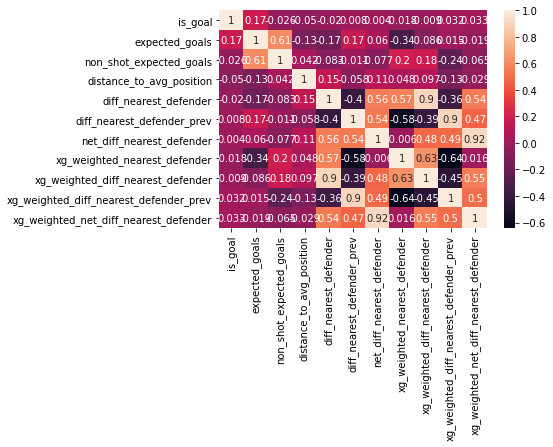

In [550]:
matrix = df_pbp_pp[['is_goal','expected_goals','non_shot_expected_goals','distance_to_avg_position','diff_nearest_defender',
       'diff_nearest_defender_prev', 'net_diff_nearest_defender',
       'xg_weighted_nearest_defender', 'xg_weighted_diff_nearest_defender',
       'xg_weighted_diff_nearest_defender_prev',
       'xg_weighted_net_diff_nearest_defender']].corr().round(3)
sns.heatmap(matrix, annot=True)
plt.show()

In [551]:
df_pbp_pp.columns

Index(['level_0', 'index', 'game_date', 'season_year', 'team_name',
       'opp_team_name', 'venue', 'period', 'clock_seconds', 'situation_type',
       'goals_for', 'goals_against', 'player_name', 'event',
       'event_successful', 'x_coord', 'y_coord', 'event_type', 'player_name_2',
       'x_coord_2', 'y_coord_2', 'event_detail_1', 'event_detail_2',
       'event_detail_3', 'frame_id_1', 'frame_id_2', 'home_team', 'away_team',
       'game_id', 'is_shot', 'is_goal', 'event_id', 'team_id', 'player_id',
       'detail_1_code', 'goal_diff', 'game_seconds_remaining', 'event_code',
       'event_type_code', 'skaters_for', 'skaters_against', 'strength_state',
       'distance_to_goal', 'angle_to_goal', 'prev_event', 'prev_event_code',
       'prev_event_type', 'prev_event_type_code', 'prev_event_x_coord',
       'prev_event_y_coord', 'prev_event_game_seconds_remaining',
       'prev_event_distance_to_goal', 'prev_event_angle_to_goal',
       'time_diff_last_event', 'angle_diff_last_event